In [11]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import os

# Function to apply bandpass filter
def bandpass_filter(data, lowcut, highcut, sample_rate, order):
    b, a = butter(order, [lowcut, highcut], btype='band', fs=sample_rate)
    y = filtfilt(b, a, data)
    return y

# Function to compute FFT
def compute_fft(signal, sample_rate, start_freq, end_freq):
    N = len(signal)  # Length of the signal (1024 samples in this case)
    fft_vals = np.fft.fft(signal)
    fft_vals = 2 * np.abs(fft_vals) / N  # Normalized magnitude
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    
    # Only take the positive frequencies (since FFT is symmetric)
    positive_freqs = freqs[:N//2]
    positive_fft_vals = fft_vals[:N//2]
    
    mask = (positive_freqs >= start_freq) & (positive_freqs <= end_freq)
    return positive_freqs[mask], positive_fft_vals[mask]

# Set up parameters and paths
required_freqs = np.arange(9.25, 15.25, 0.5)  # Frequencies of interest
base_path = r"E:\ain8sept\12JFPM_SSVEP\data"  # Base directory containing subject folders
subjects = [f's{i}' for i in range(1, 11)]  # Subject names s1 to s9
targets = [f'Target{i}' for i in range(1, 13)]  # Target names Target1 to Target12
sample_rate = 256  # in Hz
lowcut = 6  # lower cutoff frequency in Hz
highcut = 80  # upper cutoff frequency in Hz
order = 4  # filter order
start_freq = 8  # start frequency in Hz
end_freq = 30  # end frequency in Hz
num_trials_per_subject = 15  # Number of trials per subject

# Create an empty list to hold the data
data_list = []

# Loop through all targets
for target in targets:
    # Loop through all subjects
    for subject in subjects:
        subject_path = f"{base_path}/{subject}/{target}"
        
        # Loop through 15 files for each subject (15 trials per target)
        for trial_num in range(1, num_trials_per_subject + 1):
            # Load the file
            file_path = f"{subject_path}/{trial_num}.csv"
            data = pd.read_csv(file_path, header=None)
            
            # Example of using the functions for a single trial (1024 samples)
            single_trial = data.iloc[7, :]  # Replace with the appropriate row in your data
            
            # Apply bandpass filter
            filtered_signal = bandpass_filter(single_trial, lowcut, highcut, sample_rate, order)
            
            # Compute FFT
            freqs, fft_vals = compute_fft(filtered_signal, sample_rate, start_freq, end_freq)
            
            # Extract the FFT values corresponding to the required frequencies
            trial_features = []
            for freq in required_freqs:
                # Find the index of the required frequency in the computed FFT results
                idx = np.argmin(np.abs(freqs - freq))
                trial_features.append(fft_vals[idx])
            
            # Append the trial features along with the target label
            trial_data = trial_features + [target]  # Add the target label at the end
            data_list.append(trial_data)

# Convert the list of data to a DataFrame
columns = list(required_freqs) + ['Target']  # Required frequencies as column names and 'Target' label
final_features_df = pd.DataFrame(data_list, columns=columns)

# Display the final features DataFrame
print(final_features_df)

# Save the final features DataFrame to a CSV file
final_features_df.to_csv(r"E:\ain8sept\project\0.5\all_trials_featuresO2.csv", index=False)


          9.25      9.75     10.25     10.75     11.25     11.75     12.25  \
0     0.685870  1.013952  1.906811  0.059949  1.158145  0.922762  0.069354   
1     1.394814  0.698745  1.002103  1.186168  1.494197  1.459603  0.597591   
2     0.692125  1.128582  2.007842  1.837019  1.760091  1.126526  0.172081   
3     1.088172  0.829939  0.534962  0.248606  0.991082  0.462004  0.404546   
4     1.333602  1.142174  0.777284  1.456483  1.319474  0.525384  0.476489   
...        ...       ...       ...       ...       ...       ...       ...   
1795  0.502931  0.135331  0.840910  0.361528  1.717708  0.863681  1.259917   
1796  1.213132  0.610980  1.195162  1.534527  0.642007  1.794448  0.268535   
1797  1.122520  1.577845  2.986767  1.283220  1.491647  0.182793  2.386331   
1798  1.023888  0.420549  0.186749  1.048328  0.434803  1.348570  0.790478   
1799  0.501089  0.864574  0.572239  0.249024  0.598297  0.372656  0.526843   

         12.75     13.25     13.75     14.25     14.75    Targe

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the features and target labels
features = pd.read_csv(r"E:\ain8sept\project\0.5\allboth.csv")

# Separate the features (FFT values) and the target labels
X = features.drop(columns=['Target'])  # FFT values
y = features['Target']  # Target labels

# Scale the features (only the FFT values, not the target labels)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicting on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Support Vector Machine Classifier

In [21]:
from sklearn.svm import SVC
import pandas as pd

# Load the features and target labels
features = pd.read_csv(r"E:\ain8sept\project\0.25\all_trials_featuresO2.csv")

# Separate the features (FFT values) and the target labels
X = features.drop(columns=['Target'])  # FFT values
y = features['Target']  # Target labels

# Scale the features (only the FFT values, not the target labels)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=42)
clf = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")

SVM Accuracy: 64.44%


Voting Classifier

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

# Load the features and target labels
features = pd.read_csv(r"E:\ain8sept\project\0.25\allboth.csv")

# Separate the features (FFT values) and the target labels
X = features.drop(columns=['Target'])  # FFT values
y = features['Target']  # Target labels

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=42)

# Initialize the individual classifiers
clf1 = SVC(kernel='rbf', C=1, gamma='auto', random_state=42, probability=True)  # Set probability=True for soft voting
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2)], voting='soft')  # Use 'hard' or 'soft'

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict using the voting classifier
y_pred = voting_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy * 100:.2f}%")


Voting Classifier Accuracy: 71.94%


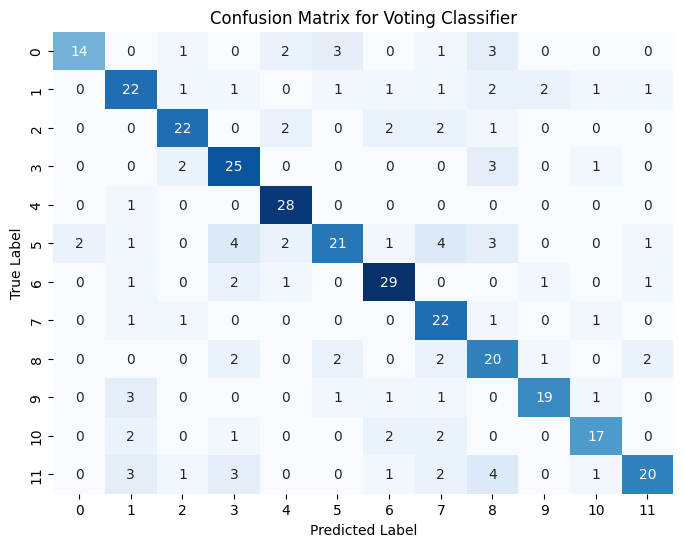

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for one of the models (e.g., Voting Classifier)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

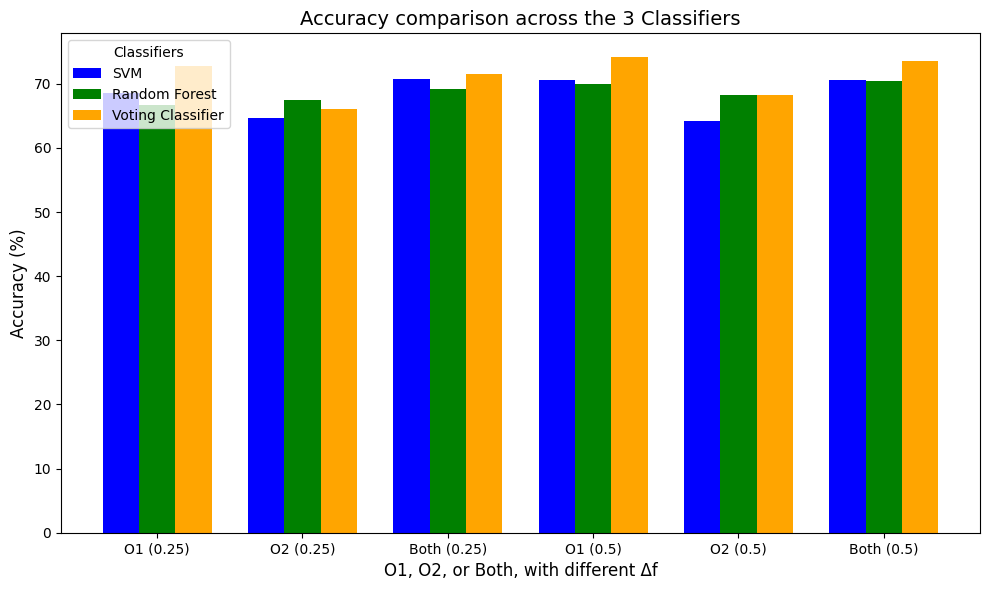

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define the x-axis labels and spacing
x_labels = ['O1 (0.25)', 'O2 (0.25)', 'Both (0.25)', 'O1 (0.5)', 'O2 (0.5)', 'Both (0.5)']
x = np.arange(len(x_labels))  # Create an array of positions for the x-axis labels

# Define the accuracies for each classifier at each x-axis point
# (Replace these with your actual accuracy values)
accuracies_rf = [66.7, 67.5, 69.2, 70.0, 68.3, 70.5]   # Accuracies for Random Forest
accuracies_svm = [68.61, 64.72, 70.82, 70.65, 64.17, 70.56]  # Accuracies for SVM
accuracies_vc = [72.78, 66.11, 71.49, 74.17, 68.33, 73.61]   # Accuracies for Voting Classifier

# Define the width of the bars
bar_width = 0.25

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each classifier's accuracies using different colors and offsets
plt.bar(x - bar_width, accuracies_svm, width=bar_width, color='blue', label='SVM')
plt.bar(x, accuracies_rf, width=bar_width, color='green', label='Random Forest')
plt.bar(x + bar_width, accuracies_vc, width=bar_width, color='orange', label='Voting Classifier')

# Add x-axis labels
plt.xticks(x, x_labels)

# Add labels and title
plt.xlabel('O1, O2, or Both, with different Δf', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy comparison across the 3 Classifiers', fontsize=14)

# Add legend for the classifiers
plt.legend(title='Classifiers', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
